# Churn -  Modelagem -  XGBoost

## ÍNDICE: 

1. [Bibliotecas](#Bibliotecas)  
2. [Tratamento da Base](#Tratamento-da-Base)   
    2.1. [Trazer a Tabela](#Trazer-a-Tabela)  
3. [Seleção de Variáveis](#Seleção-de-Variáveis)   
    3.1. [Variáveis mais Relevantes](#Variáveis-mais-Relevantes)  
    3.2. [RFE](#RFE)        
4. [Modelagem](#Modelagem)  
    4.1. [Tabela Arrumada](#Tabela-Arrumada)   
    4.2. [Melhorar os Parâmetros](#Melhorar-os-Parâmetros)
5. [Resultados](#Resultados)  
    5.1. [Verificar o Modelo](#Verificar-o-Modelo)  
    5.2. [Gráfico thresholds](#Gráfico-thresholds)
  
  
### APÊNDICE:    


1. [Função Matriz de confusão](#Função-Matriz-de-confusão) 
2. [Função Treino](#Função-Treino)

# Bibliotecas

In [3]:
### Import das bases usadas

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time
import warnings
import locale
import random
%matplotlib inline

#Importar a biblioteca do modelo XGBoost

from sklearn.cross_validation import train_test_split
import xgboost as xgb

#Importar as bibliotecas do RFE

from sklearn import datasets
from sklearn.feature_selection import RFE

#Importar as bibliotecas para a Modelagem 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#Importar as bibliotecas para a Matriz de confusão

import itertools
from sklearn.metrics import confusion_matrix


/opt/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Tratamento da Base

* Voltar: [ÍNDICE:](#ÍNDICE:)


### Trazer a Tabela 

* Trago a safra 1 do modelo.
* Verifico a relação do meu Target de classificação.
* Trato as colunas categóricas para dummies.
* Verifico a existência de valores NULLS(NaN).
* Trato os valores NULLS.

In [4]:
#Conta o tempo de execução para trazer a tabela

t1 = time.time()
df = pd.read_csv("/home/thase/projetos_dcd/queries/TES1.csv", sep = ";")
t2 = time.time()
t2-t1

14.682602882385254

In [5]:
#Ver a tabela 

df.head()

CPF_MASC15  churn  TED_VL_m1  TED_VL_m2  TED_VL_m3  TED_VL_m4  \
0  0B71B5160109249   True        0.0        0.0        0.0        0.0   
1  F8D0F2319C5DB82  False        0.0        0.0        0.0        0.0   
2  CF360AFE42DEB42  False        0.0        0.0        0.0        0.0   
3  E7BB95D849CDDBC  False        0.0        0.0        0.0        0.0   
4  951360767AE21F5  False        0.0        0.0        0.0        0.0   

   TED_Q_m1  TED_Q_m2  TED_Q_m3  TED_Q_m4      ...        Aplic_LF  \
0         0         0         0         0      ...             0.0   
1         0         0         0         0      ...             0.0   
2         0         0         0         0      ...             0.0   
3         0         0         0         0      ...             0.0   
4         0         0         0         0      ...             0.0   

   Saldo_Medio_MULTIMER  Resgate_MULTIMER  Aplic_MULTIMER  Saldo_Medio_OUTROS  \
0                   0.0               0.0             0.0                 0.0   
1                   0.0               0.0             0.0                 0.0   
2                   0.0               0.0             0.0                 0.0   
3                   0.0               0.0             0.0                 0.0   
4                   0.0               0.0             0.0                 0.0   

   Resgate_OUTROS  Aplic_OUTROS  Saldo_Medio_RENDAFI  Resgate_RENDAFI  \
0             0.0           0.0            17220.665              0.0   
1             0.0           0.0                0.000              0.0   
2             0.0           0.0                0.000              0.0   
3             0.0           0.0                0.000              0.0   
4             0.0           0.0                0.000              0.0   

   Aplic_RENDAFI  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 193 columns]

In [6]:
#Ver quantos valores do meu target tem, em número absoluto e porcentagem 

print("Quantidade de churns na Safra1")
a = pd.DataFrame(df["churn"].value_counts())
a["%"] = (df["churn"].value_counts(True)*100).round()
a

Quantidade de churns na Safra1


churn     %
False  734677  98.0
True    17033   2.0

In [7]:
#Criar uma lista categórica para fazer as dummies. 
#Executar uma função que cria as dummies e deleta uma delas 

a= ["ESTADO","DS_SEGMENTO_CLIENTE","IN_SEXO","DESC_IMV","SITUACAO_IMV","CSIT_PNHOR_HIPOT"]
df00 = pd.get_dummies(df, columns=a, dummy_na=True,  drop_first=True)

In [8]:
#Ver quais colunas possui algum valor NULL (NaN)

df00.loc[:, df00.isnull().any()]

CD_ESTADO_CIVIL  CD_CATEGORIA_PROFISSIONAL
0                   NaN                        NaN
1                   2.0                        7.0
2                   1.0                        3.0
3                   1.0                        1.0
4                   9.0                        1.0
5                   2.0                        6.0
6                   3.0                        1.0
7                   2.0                        7.0
8                   1.0                        6.0
9                   9.0                       12.0
10                  2.0                        7.0
11                  1.0                        1.0
12                  2.0                        7.0
13                  2.0                        1.0
14                  NaN                        NaN
15                  1.0                        1.0
16                  5.0                        6.0
17                  3.0                        1.0
18                  1.0                        5.0
19                  1.0                       12.0
20                  1.0                        1.0
21                  2.0                        7.0
22                  6.0                        1.0
23                  9.0                       10.0
24                  1.0                        1.0
25                  3.0                        1.0
26                  2.0                        1.0
27                  2.0                        8.0
28                  1.0                       10.0
29                  1.0                        1.0
...                 ...                        ...
751680              1.0                        7.0
751681              2.0                        1.0
751682              1.0                        8.0
751683              3.0                        1.0
751684              2.0                        7.0
751685              2.0                        6.0
751686              2.0                        1.0
751687              2.0                        7.0
751688              3.0                        1.0
751689              2.0                        8.0
751690              1.0                        8.0
751691              2.0                        6.0
751692              1.0                       10.0
751693              1.0                       10.0
751694              2.0                        7.0
751695              1.0                        6.0
751696              9.0                        1.0
751697              2.0                       10.0
751698              1.0                        1.0
751699              1.0                       12.0
751700              2.0                        7.0
751701              1.0                        7.0
751702              9.0                        7.0
751703              2.0                        6.0
751704              1.0                        7.0
751705              1.0                       12.0
751706              3.0                        1.0
751707              9.0                        7.0
751708              1.0                        1.0
751709              9.0                        1.0

[751710 rows x 2 columns]

In [9]:
#Tratar os NULLS por (-1)

df00.fillna(value =-1 , inplace=True)

In [10]:
#Ver a tabela

df00.head()

CPF_MASC15  churn  TED_VL_m1  TED_VL_m2  TED_VL_m3  TED_VL_m4  \
0  0B71B5160109249   True        0.0        0.0        0.0        0.0   
1  F8D0F2319C5DB82  False        0.0        0.0        0.0        0.0   
2  CF360AFE42DEB42  False        0.0        0.0        0.0        0.0   
3  E7BB95D849CDDBC  False        0.0        0.0        0.0        0.0   
4  951360767AE21F5  False        0.0        0.0        0.0        0.0   

   TED_Q_m1  TED_Q_m2  TED_Q_m3  TED_Q_m4          ...           IN_SEXO_nan  \
0         0         0         0         0          ...                     1   
1         0         0         0         0          ...                     0   
2         0         0         0         0          ...                     0   
3         0         0         0         0          ...                     0   
4         0         0         0         0          ...                     0   

   DESC_IMV_OUTROS  DESC_IMV_RESIDENCIAL  DESC_IMV_RURAL  DESC_IMV_VAZIO  \
0                0                     0               0               0   
1                0                     0               0               1   
2                0                     0               0               1   
3                0                     0               0               1   
4                0                     0               0               1   

   DESC_IMV_nan  SITUACAO_IMV_D  SITUACAO_IMV_nan  CSIT_PNHOR_HIPOT_P  \
0             1               0                 1                   0   
1             0               0                 1                   0   
2             0               0                 1                   0   
3             0               0                 1                   0   
4             0               0                 1                   0   

   CSIT_PNHOR_HIPOT_nan  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  

[5 rows x 247 columns]

# Seleção de Variáveis

* Voltar: [ÍNDICE:](#ÍNDICE:)

### Variáveis mais Relevantes

* Trazer a função que separa a minha tabela em treino e teste.
* Separar as variáveis explicativas e a variável resposta.
* Rodar o modelo para trazer as variáveis mais importantes.
    * Obs: Caso precise, usar o RFE para a seleção de variáveis.
* Filtrar a tabela com as variáveis mais significativas para o modelo.
    * Obs: Fazer esse processo para o RFE também.
* Fazer um mapa de calor para analisar as correlações entre as variáveis. 
    * Obs: Fazer esse processo para o RFE também.

In [10]:
#Separar as variáveis explicativas e a variável resposta

#x => variáveis explicativas e y=> variável resposta

x = df00[[x for x in df00.columns if x!='churn' and  x!='CPF_MASC15']]
y = df00['churn']

In [64]:
#Função que separa a tabela em parte de treino(70%) e teste(30%)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=7)

#Função Extreme Gradient Boosting (XGBoost)

rf = xgb.XGBClassifier(n_estimators=200,learning_rate=0.4,max_depth=9, min_child_weight=1,max_delta_step=1,gamma=0,subsample=1,colsample_bytree=0.7, nthread=-1,scale_pos_weight=43).fit(x_train, y_train)

#Função que traz o nome das colunas com o respectivo ranking de importância para o modelo

feature_importances = pd.DataFrame(rf.feature_importances_, index = x_train.columns, columns=['importance']).sort_values('importance',ascending=False)
a = feature_importances[feature_importances["importance"]>0.01]

#Salvar numa tabela

a.to_csv("var_xgb3.csv", index=True)

In [11]:
#Trazer a tabela das melhores variáveis

lista_var = pd.read_csv("/home/thase/projetos_dcd/queries/var_xgb3.csv", sep = ",")
lista_var

var  importance
0                    VR_RENDA    0.093409
1                TED_VL_TOTAL    0.077232
2         Saldo_Medio_RENDAFI    0.056664
3                   TEMPO_MOV    0.055519
4             Saldo_Medio_CDB    0.050663
5                  QTD_CONTAS    0.047601
6                   MIN_CONTA    0.040487
7                  MEDIANA_m4    0.037673
8                  MEDIANA_m1    0.032167
9             Resgate_RENDAFI    0.031518
10             FOLHA_VL_total    0.030775
11                  SOMA_REST    0.029445
12                 MEDIANA_m3    0.029198
13              VL_TOTAL_REST    0.027651
14              VL_MEDIO_REST    0.026321
15                Resgate_CDB    0.026260
16                VL_MIN_REST    0.025641
17  CD_CATEGORIA_PROFISSIONAL    0.025579
18       Saldo_Medio_HIPERFUN    0.024589
19              Aplic_RENDAFI    0.024558
20            CD_ESTADO_CIVIL    0.022548
21        ANOS_COM_RESTRITIVO    0.022424
22                 MEDIANA_m2    0.021620
23                  TED_VL_m2    0.021465
24    ANOS_RESTRITIVO_RECENTE    0.020197
25          Saldo_Medio_ACOES    0.018187
26             Num_Pgto_total    0.018063
27                 TED_Q_m4_T    0.017630
28                  Aplic_CDB    0.017166
29       Saldo_Medio_MULTIMER    0.016455
30         Saldo_Medio_OUTROS    0.011289

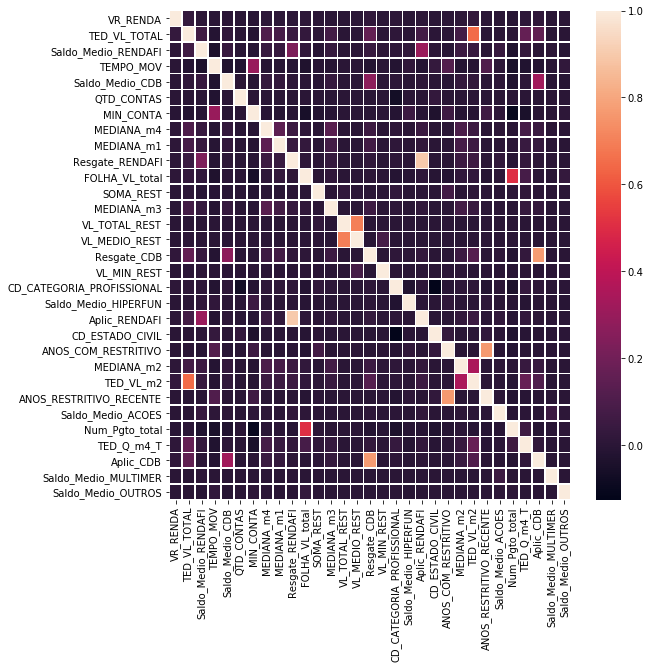

In [12]:
#Mapa de calor

fig, ax = plt.subplots(figsize=(9,9)) 
sns.heatmap(df[list(lista_var["var"])].corr(),annot=False, linewidths=.5, ax=ax)

In [13]:
#Retirar os valores correlacionados

#Valores permanecentes 

lista_var1 = ['VR_RENDA','TED_VL_TOTAL','Saldo_Medio_RENDAFI','TEMPO_MOV','Saldo_Medio_CDB','QTD_CONTAS','MIN_CONTA','MEDIANA_m4','MEDIANA_m1','Resgate_RENDAFI','FOLHA_VL_total','SOMA_REST','MEDIANA_m3','VL_TOTAL_REST','Resgate_CDB','VL_MIN_REST','CD_CATEGORIA_PROFISSIONAL','Saldo_Medio_HIPERFUN','CD_ESTADO_CIVIL','ANOS_COM_RESTRITIVO','MEDIANA_m2','Saldo_Medio_ACOES','TED_Q_m4_T','Saldo_Medio_MULTIMER','Saldo_Medio_OUTROS']

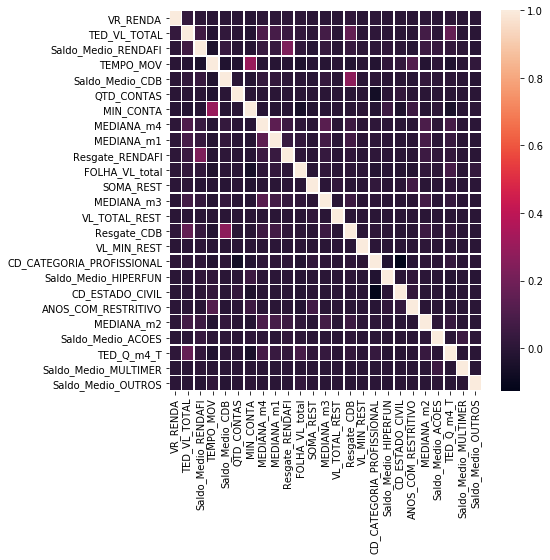

In [14]:
#Mapa de calor

fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(df[lista_var1].corr(),annot=False, linewidths=.5, ax=ax)

In [14]:
#Tabela arrumada
lista_var2 = lista_var1 + ["CPF_MASC15", "churn"]

In [28]:
#Salvar a tabela

df[lista_var2].to_csv("/home/thase/projetos_dcd/queries/safra1_arrumada.csv", index=True)

11.552557945251465

# ---------------------------------------------------------------------------------------------------------------
# ---------------------------------  CASO PRECISE DO RFE  ----------------------------------------
# ---------------------------------------------------------------------------------------------------------------


## RFE

Feature ranking with recursive feature elimination.
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination **(RFE)** is to select features by recursively considering smaller and smaller sets of features. 

* Voltar: [ÍNDICE:](#ÍNDICE:)

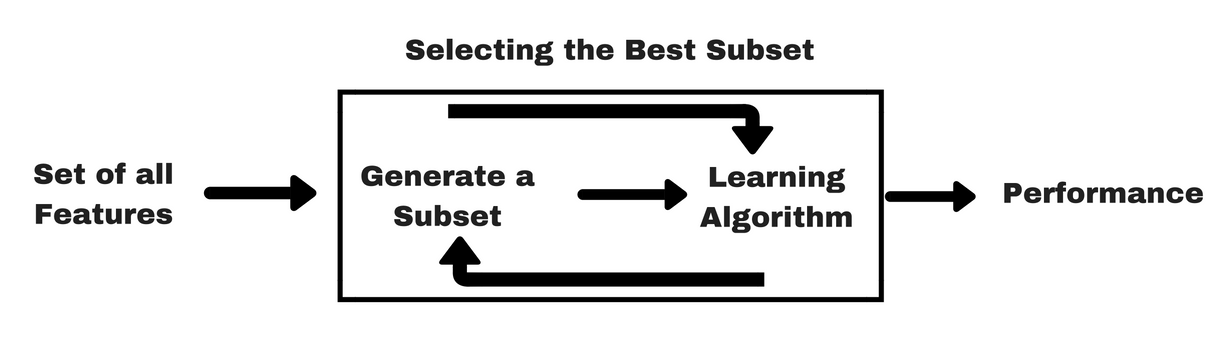

In [19]:
from IPython.display import Image
Image(filename='Wrapper_1.png')

In [16]:
#Separar as variáveis explicativas e a variável resposta

#x => variáveis explicativas e y=> variável resposta

x = df00[[x for x in df00.columns if x!='churn' and  x!='CPF_MASC15']]
y = df00['churn']

In [ ]:
#Tempo de execução 

t1 = time.time()

#Função Extreme Gradient Boosting (XGBoost)

rfe = xgb.XGBClassifier(n_estimators=200,learning_rate=0.4,max_depth=9, min_child_weight=1,max_delta_step=1,gamma=0,subsample=1,colsample_bytree=0.7, nthread=-1,scale_pos_weight=43)

#Função RFE, escolhe as variáveis mais importantes (nesse caso, escolhe 1 variável) 

rfe = RFE(model,1)
rfe = rfe.fit(x, y)


# Check as variáveis selecionadas

rfe.fit_transform(x.as_matrix(), y.as_matrix())
features_bool = np.array(rfe.support_)
features = np.array(x.columns)
result = features[features_bool]
print(result)

t2 = time.time()
print("Tempo de execução:\n")
print(t2-t1)


In [ ]:
#Criar a tabela 

a = pd.DataFrame({'var':x.columns})
a['ranking'] = rfe.ranking_
b=a.sort_values("ranking")

# arrumar index

b.index = np.arange(0,len(a))

#salvar em csv

b.to_csv("/home/thase/projetos_dcd/queries/var_tudo.csv", index=True)


In [17]:
#Trazer a tabela

lista = pd.read_csv("/home/thase/projetos_dcd/queries/var_tudo.csv", sep = ",")

In [21]:
#Ver a tabela

lista.head(10)

Unnamed: 0            var  ranking
0           0   TED_VL_TOTAL        1
1           1       VR_RENDA        2
2           2  IDADE_CLIENTE        3
3           3  TED_QTD_TOTAL        4
4           4      MAX_CONTA        5
5           5      TEMPO_MOV        6
6           6     QTD_CONTAS        7
7           7      MIN_CONTA        8
8           8    VL_MAX_REST        9
9           9     MEDIANA_m4       10

In [26]:
#Corte de ranking e adicionar a variável ["churn" e "CPF_MASC15"]

l1 = lista[lista["ranking"]<=30]
l2 = list(l1["var"])
l3 = l2 + ["CPF_MASC15", "churn"]

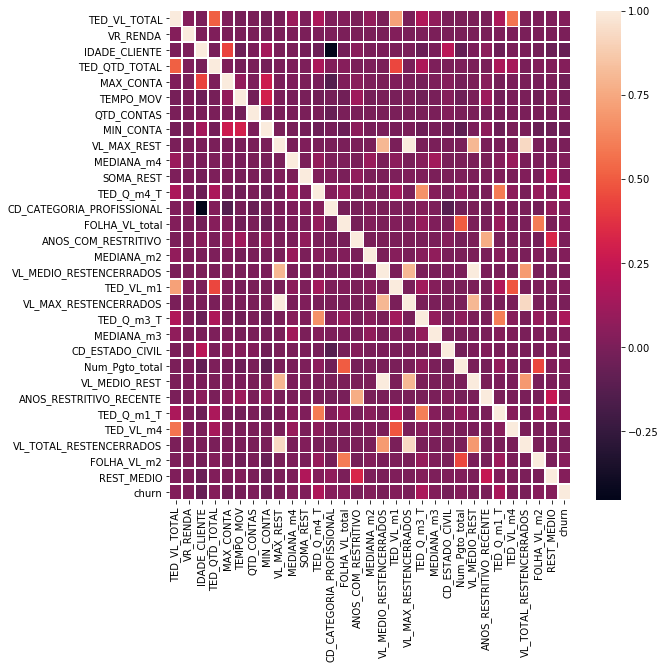

In [29]:
#Mapa de calor

fig, ax = plt.subplots(figsize=(9,9)) 
sns.heatmap(df[l3].corr(),annot=False, linewidths=.5, ax=ax)

In [ ]:
#Salvar a tabela

df[l3].to_csv("/home/thase/projetos_dcd/queries/safra1_arrumada.csv", index=True)

# Modelagem

* Voltar: [ÍNDICE:](#ÍNDICE:)

### Tabela Arrumada

* Trago a tabela arrumada.
* Separo as variáveis explicativas e a variável resposta.
* Divido a tabela em treino e teste.
* Melhoro os parametros do modelo.

In [49]:
#Conta o tempo de execução para trazer a tabela

t1 = time.time()
df = pd.read_csv("/home/thase/projetos_dcd/queries/safra1_arrumada.csv")
t2 = time.time()
t2-t1

2.3436431884765625

In [50]:
#Deletar coluna e ver a tabela

df.drop("Unnamed: 0", axis=1, inplace = True)
df.head()

VR_RENDA  TED_VL_TOTAL  Saldo_Medio_RENDAFI  TEMPO_MOV  Saldo_Medio_CDB  \
0      0.00           0.0            17220.665       -352              0.0   
1   3800.00           0.0                0.000          6              0.0   
2  16223.49           0.0                0.000         18              0.0   
3   2301.00           0.0                0.000         17              0.0   
4   6567.93           0.0                0.000          4              0.0   

   QTD_CONTAS  MIN_CONTA  MEDIANA_m4  MEDIANA_m1  Resgate_RENDAFI  ...    \
0     4597560          0         0.0         0.0              0.0  ...     
1           7          1         0.0         0.0              0.0  ...     
2           4          2         0.0         0.0              0.0  ...     
3           7          5         0.0         0.0              0.0  ...     
4           9          1         0.0         0.0              0.0  ...     

   Saldo_Medio_HIPERFUN  CD_ESTADO_CIVIL  ANOS_COM_RESTRITIVO  MEDIANA_m2  \
0               0.00000              NaN                    0         0.0   
1           32299.98625              2.0                   15         0.0   
2               0.00000              1.0                    5         0.0   
3            2442.74875              1.0                   18         0.0   
4               0.00000              9.0                    5         0.0   

   Saldo_Medio_ACOES  TED_Q_m4_T  Saldo_Medio_MULTIMER  Saldo_Medio_OUTROS  \
0                0.0           0                   0.0                 0.0   
1                0.0           0                   0.0                 0.0   
2                0.0           0                   0.0                 0.0   
3                0.0           0                   0.0                 0.0   
4                0.0           0                   0.0                 0.0   

        CPF_MASC15  churn  
0  0B71B5160109249   True  
1  F8D0F2319C5DB82  False  
2  CF360AFE42DEB42  False  
3  E7BB95D849CDDBC  False  
4  951360767AE21F5  False  

[5 rows x 27 columns]

In [47]:
#Separar as variáveis explicativas e a variável resposta

#x => variáveis explicativas e y=> variável resposta

x = df[[x for x in df.columns if x!='churn' and  x!='CPF_MASC15']]
y = df['churn']

In [61]:
#Separar em treino(70%) e teste(30%)

X_, X_test, y_, y_test = train_test_split(x, y, test_size = 0.3)

### Melhorar os Parâmetros

* Parâmetros para melhorar:
* [n_estimators](#n_estimators)
* [max_depth e min_child_weight](#max_depth-e-min_child_weight)
* [subsample e max_delta_step](#subsample-e-max_delta_step)
* [learning_rate](#learning_rate)

#### n_estimators

In [63]:
#parametro n_estimators

cv_params = {'n_estimators': [10,50,100]}    
fix_params = {'learning_rate': 0.1, 'objective': 'binary:logistic', "scale_pos_weight":43}   #other parameters, fixed for the moment 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1',n_jobs=-1,cv = kfold)

In [64]:
csv.fit(X_, y_)
csv.grid_scores_

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/opt/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.09844, std: 0.00170, params: {'n_estimators': 10},
 mean: 0.11125, std: 0.00379, params: {'n_estimators': 50},
 mean: 0.11779, std: 0.00305, params: {'n_estimators': 100}]

In [65]:
print ("Melhor parametro: {}".format(csv.best_params_))

Melhor parametro: {'n_estimators': 100}


#### max_depth e min_child_weight

In [68]:
#parametro: max_depth e min_child_weight

cv_params = {'max_depth': [3,9], 'min_child_weight': [1,3]}    # parameters to be tried in the grid search
fix_params = {'n_estimators':100, 'learning_rate': 0.1, 'objective': 'binary:logistic', "scale_pos_weight":43}   #other parameters, fixed for the moment 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1',n_jobs=-1,cv = kfold)

In [69]:
csv.fit(X_, y_)
csv.grid_scores_

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

[mean: 0.11779, std: 0.00305, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.11667, std: 0.00470, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.14366, std: 0.00945, params: {'max_depth': 9, 'min_child_weight': 1},
 mean: 0.14596, std: 0.00765, params: {'max_depth': 9, 'min_child_weight': 3}]

In [70]:
print ("Melhor parametro: {}".format(csv.best_params_))

Melhor parametro: {'max_depth': 9, 'min_child_weight': 3}


#### subsample e max_delta_step

In [87]:
#parametro: subsample e max_delta_step

cv_params = {'subsample': [0.8,1], 'max_delta_step': [0,2,4]}
fix_params = {'max_depth':9,'min_child_weight':3,'n_estimators':100, 'learning_rate': 0.1, 'objective': 'binary:logistic', "scale_pos_weight":43}   #other parameters, fixed for the moment 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1',n_jobs=-1,cv = kfold)

In [88]:
csv.fit(X_, y_)
csv.grid_scores_

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/opt/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.15824, std: 0.01267, params: {'subsample': 0.8, 'max_delta_step': 0},
 mean: 0.14596, std: 0.00765, params: {'subsample': 1, 'max_delta_step': 0},
 mean: 0.15610, std: 0.01515, params: {'subsample': 0.8, 'max_delta_step': 2},
 mean: 0.14871, std: 0.01039, params: {'subsample': 1, 'max_delta_step': 2},
 mean: 0.15475, std: 0.01892, params: {'subsample': 0.8, 'max_delta_step': 4},
 mean: 0.14410, std: 0.00988, params: {'subsample': 1, 'max_delta_step': 4}]

In [89]:
print ("Melhor parametro: {}".format(csv.best_params_))

Melhor parametro: {'subsample': 0.8, 'max_delta_step': 0}


#### learning_rate

In [90]:
cv_params = {'learning_rate': [0.1, 0.15]}
fix_params = {'max_delta_step': 0, 'subsample': 0.8, 'max_depth':9,'min_child_weight':3,'n_estimators':100,'objective': 'binary:logistic', "scale_pos_weight":43}   #other parameters, fixed for the moment 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1',n_jobs=-1,cv = kfold)

In [91]:
csv.fit(X_, y_)
csv.grid_scores_

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

[mean: 0.15824, std: 0.01267, params: {'learning_rate': 0.1},
 mean: 0.13572, std: 0.02322, params: {'learning_rate': 0.15}]

In [92]:
print ("Melhor parametro: {}".format(csv.best_params_))

Melhor parametro: {'learning_rate': 0.1}


### ------------------------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------------------------
### Melhor parametro: {'n_estimators': 100}
### Melhor parametro: {'max_depth': 9, 'min_child_weight': 3}
### Melhor parametro: {'subsample': 0.8, 'max_delta_step': 0}
### Melhor parametro: {'learning_rate': 0.1}
### ------------------------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------------------------


# Resultados

### Verificar o Modelo

* Executar a [Função Matriz de confusão](#Função-Matriz-de-confusão) e a [Função Treino](#Função-Treino) antes.  
* Executar o modelo padrão.
* Executar o modelo com os melhores parâmetros.
* Verificar se o modelo não tem Overffit


* Voltar: [ÍNDICE:](#ÍNDICE:)

In [53]:
#Separar as variáveis explicativas e a variável resposta

#x => variáveis explicativas e y=> variável resposta

x = df[[x for x in df.columns if x!='churn' and  x!='CPF_MASC15']]
y = df['churn'].values

#Criar um array com todos os índices da tabela

allIndices = np.arange(len(y))

#Contar o número de linhas para o Treino, Validação e Teste

numTrain = int(round(0.40*len(y)))
numValid = int(round(0.30*len(y)))
numTest = len(y)-numTrain-numValid

#Escolher aleatoriamente os índices para o Treino, Validação e Teste

random.seed(1234)
inTrain = sorted(np.random.choice(allIndices, size=numTrain, replace=False))
inValidTest = list(set(allIndices)-set(inTrain))
inValid= sorted(np.random.choice(inValidTest, size=numValid, replace=False))
inTest = list(set(inValidTest)-set(inValid))

#Criar amostra de Treino(70%), Validação(30%) e Teste(30%)

train = x.iloc[inTrain,:]
valid = x.iloc[inValid,:]
test =  x.iloc[inTest,:]

#As respostas 

trainY = y[inTrain]
validY = y[inValid]
testY  = y[inTest]

In [52]:
#Parâmetros do modelo

#Odds Ratio

scale_pos_weight = sum(trainY==0)/sum(trainY==1) 

#n_estimators

num_rounds=100 

#Parâmetros Padrão

param = {'silent':1,
         'max_delta_step': 0,
         'min_child_weight':1,
         'max_depth':3,
         'learning_rate':0.1,
         'subsample': 1,
         'scale_pos_weight':scale_pos_weight}

#Parâmetros Melhorados

param1 = {'silent':1,
         'max_delta_step': 0,
         'min_child_weight':3,
         'max_depth':9,
         'learning_rate':0.1,
         'subsample': 0.8,
         'scale_pos_weight':scale_pos_weight}


### Modelo Padrão

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Recall metric in the valid dataset: 70%
Precision metric in the valid dataset: 6%
F1 Score metric in the valid dataset: 11%


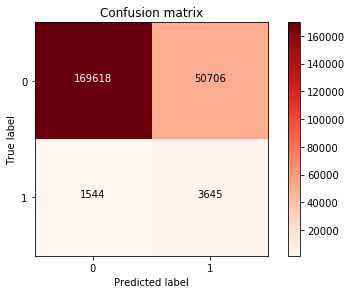

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Recall metric in the test dataset: 71%
Precision metric in the test dataset: 6%
F1 Score metric in the test dataset: 11%


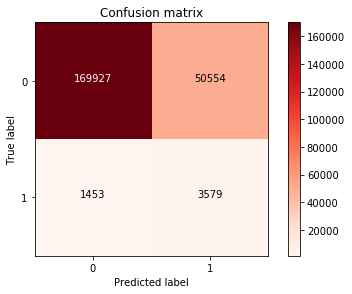

In [41]:
#Modelo Padrão: Validação e Treino

do_train(train,trainY,valid,validY,"valid",param)
do_train(train,trainY,test,testY,"test",param)

### Modelo Melhorado

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Recall metric in the valid dataset: 55%
Precision metric in the valid dataset: 8%
F1 Score metric in the valid dataset: 13%


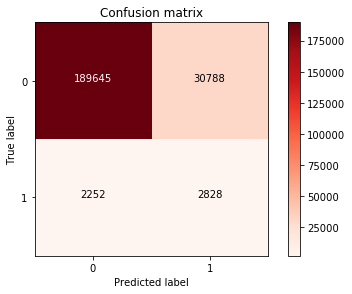

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Recall metric in the test dataset: 56%
Precision metric in the test dataset: 8%
F1 Score metric in the test dataset: 14%


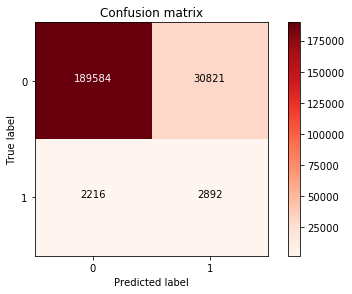

In [54]:
#Modelo Melhorado: Validação e Treino

do_train(train,trainY,valid,validY,"valid",param1)
do_train(train,trainY,test,testY,"test",param1)

**F1 Score da Validação:** 13%  
**F1 Score do Treino:** 14%

### Verificação de Overfit

[0]	validation_0-error:0.267587	validation_0-logloss:0.658335	validation_1-error:0.269279	validation_1-logloss:0.6587
[1]	validation_0-error:0.256399	validation_0-logloss:0.628091	validation_1-error:0.259812	validation_1-logloss:0.628816
[2]	validation_0-error:0.23095	validation_0-logloss:0.602972	validation_1-error:0.234057	validation_1-logloss:0.604046
[3]	validation_0-error:0.232008	validation_0-logloss:0.582178	validation_1-error:0.235357	validation_1-logloss:0.583608
[4]	validation_0-error:0.225772	validation_0-logloss:0.563855	validation_1-error:0.228993	validation_1-logloss:0.565568
[5]	validation_0-error:0.217591	validation_0-logloss:0.548798	validation_1-error:0.220586	validation_1-logloss:0.550824
[6]	validation_0-error:0.214993	validation_0-logloss:0.534917	validation_1-error:0.218338	validation_1-logloss:0.537292
[7]	validation_0-error:0.211937	validation_0-logloss:0.522827	validation_1-error:0.215726	validation_1-logloss:0.525575
[8]	validation_0-error:0.209612	validation_

[69]	validation_0-error:0.139256	validation_0-logloss:0.348365	validation_1-error:0.153024	validation_1-logloss:0.367761
[70]	validation_0-error:0.138577	validation_0-logloss:0.347235	validation_1-error:0.152608	validation_1-logloss:0.366761
[71]	validation_0-error:0.138541	validation_0-logloss:0.34644	validation_1-error:0.152497	validation_1-logloss:0.366096
[72]	validation_0-error:0.138411	validation_0-logloss:0.346078	validation_1-error:0.152395	validation_1-logloss:0.365814
[73]	validation_0-error:0.137407	validation_0-logloss:0.344476	validation_1-error:0.15161	validation_1-logloss:0.36437
[74]	validation_0-error:0.137503	validation_0-logloss:0.344033	validation_1-error:0.151676	validation_1-logloss:0.364033
[75]	validation_0-error:0.136728	validation_0-logloss:0.343051	validation_1-error:0.151299	validation_1-logloss:0.363151
[76]	validation_0-error:0.135967	validation_0-logloss:0.341331	validation_1-error:0.150417	validation_1-logloss:0.36164
[77]	validation_0-error:0.135694	val

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


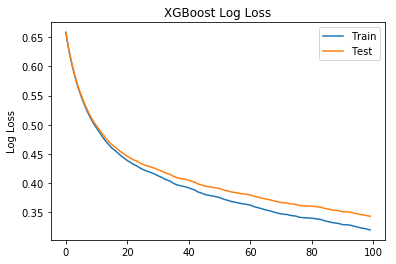

In [44]:
#Modelo

model = xgb.XGBClassifier(n_estimators=100,
                            learning_rate=0.1,
                            max_depth=9, 
                            min_child_weight=3, 
                            subsample=0.8,
                            max_delta_step=0, 
                            nthread=-1,
                            scale_pos_weight=43)

#Executar o modelo

model.fit(train, trainY, eval_metric=["error", "logloss"], eval_set=[(train, trainY), (test,testY)])
y_pred = model.predict(test)
predictions = [round(value) for value in y_pred]

#Métricas 

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

#Gráfico LogLoss x N_estimators

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

### Gráfico thresholds

In [58]:
lr = xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=9, min_child_weight=3, subsample=0.8,max_delta_step=0, nthread=-1,scale_pos_weight=43).fit(train, trainY)

predict_proba = lr.predict_proba(test)
predict = lr.predict(test)

x_test2 = test[:][:]
x_test2['prob'] = [x[1] for x in predict_proba]
x_test2['predict'] = [x for x in predict]
x_test2['churn'] = testY
x_test2.head()

x_test2['prob_40'] = False
x_test2['prob_40'][x_test2['prob'] > 0.4] = True

x_test2['prob_60'] = False
x_test2['prob_60'][x_test2['prob'] > 0.6] = True

x_test2['prob_70'] = False
x_test2['prob_70'][x_test2['prob'] > 0.7] = True

x_test2['prob_80'] = False
x_test2['prob_80'][x_test2['prob'] > 0.8] = True

x_test2['prob_90'] = False
x_test2['prob_90'][x_test2['prob'] > 0.9] = True

/opt/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying

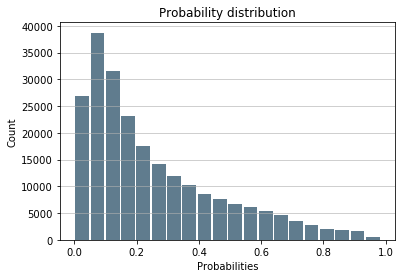

In [59]:
#import matplotlib.pyplot as plt
x_test2['prob'].plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Probability distribution')
plt.xlabel('Probabilities')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

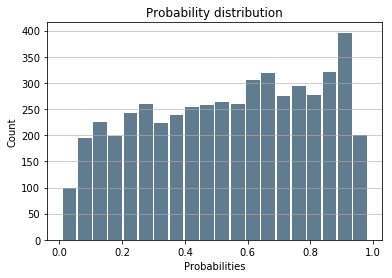

In [60]:
# Histogram to all real churns
x_test3 = x_test2.loc[x_test2['churn'] == True]

#import matplotlib.pyplot as plt
x_test3['prob'].plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Probability distribution')
plt.xlabel('Probabilities')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

In [62]:
df = pd.DataFrame({'thresholds': np.arange(0,1.01, 0.00001)})
df.head()

thresholds            cat    VP      FP  FN  precision  recall
0     0.00000  (-0.001, 0.1]  5108  220405   0   0.022651     1.0
1     0.00001  (-0.001, 0.1]  5108  220405   0   0.022651     1.0
2     0.00002  (-0.001, 0.1]  5108  220405   0   0.022651     1.0
3     0.00003  (-0.001, 0.1]  5108  220405   0   0.022651     1.0
4     0.00004  (-0.001, 0.1]  5108  220405   0   0.022651     1.0

In [65]:
#Salvar a tabela

df.to_csv("/home/thase/projetos_dcd/queries/Grafico_XGBoost.csv",index=True)

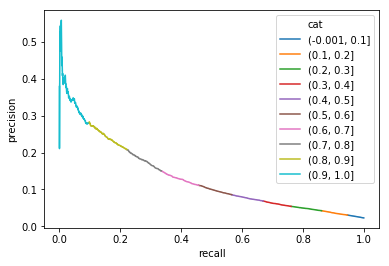

In [61]:
df['cat'] = pd.cut(df['thresholds'], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
df['VP'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob > x) & (x_test2.churn == 1)].shape[0])
df['FP'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob > x) & (x_test2.churn == 0)].shape[0])
df['FN'] = df.thresholds.apply(lambda x: x_test2[(x_test2.prob <= x) & (x_test2.churn == 1)].shape[0])
df['precision'] = df.VP/(df.VP + df.FP)
df['recall'] = df.VP/(df.VP + df.FN)
# df.fillna(0, inplace = True)
df
ax = sns.lineplot(x="recall", y="precision", hue="cat", data=df) 

### APÊNDICE: 

### Função Matriz de confusão

* Voltar: [ÍNDICE:](#ÍNDICE:)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Função Treino

* Voltar: [ÍNDICE:](#ÍNDICE:)

In [56]:
def do_train(x,y,x1,y1,text,param):


    rf = xgb.XGBClassifier(**param).fit(x,y)

    y_pre = rf.predict(x1)

    cnf_matrix_tra = confusion_matrix(y1, y_pre)

    recall = 100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])
    precision = 100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[0,1]+cnf_matrix_tra[1,1])
    f1 = 2*(recall*precision)/(recall+precision)

    print("Recall metric in the {} dataset: {}%".format(text,recall))
    print("Precision metric in the {} dataset: {}%".format(text,precision))
    print("F1 Score metric in the {} dataset: {}%".format(text,f1))

    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
    plt.show()
